In this notebook we will explore features of the Python API that allow us to import and manipulate resonance covariance data. A full description of the ENDF-VI and ENDF-VII formats can be found in the [ENDF102 manual](https://www.oecd-nea.org/dbdata/data/manual-endf/endf102.pdf).

In [1]:
%matplotlib inline
import os
from pprint import pprint
import shutil
import subprocess
import urllib.request

import h5py
import numpy as np
import matplotlib.pyplot as plt

import openmc.data

### ENDF: Resonance Covariance Data

Let's download the ENDF/B-VII.1 evaluation for $^{157}$Gd and load it in:

In [2]:
# Download ENDF file
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Gd/157'
filename, headers = urllib.request.urlretrieve(url, 'gd157.endf')

# Load into memory
gd157_endf = openmc.data.IncidentNeutron.from_endf(filename, covariance=True)
gd157_endf

<IncidentNeutron: Gd157>

We can access the parameters contained within File 32 in a similar manner to the File 2 parameters from before. 

In [3]:
gd157_endf.resonance_covariance.ranges[0].parameters[:5]

,energy,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB,L
0,0.0314,2.0,0.000474,0.1072,0.0,0.0,0
1,2.8250,2.0,0.000345,0.0970,0.0,0.0,0
2,16.2400,1.0,0.000400,0.0910,0.0,0.0,0
3,16.7700,2.0,0.012800,0.0805,0.0,0.0,0
4,20.5600,2.0,0.011360,0.0880,0.0,0.0,0


The newly created object will contain multiple resonance regions within `gd157_endf.resonance_covariance.ranges`. We can access the full covariance matrix from File 32 for a given range by:

In [4]:
covariance = gd157_endf.resonance_covariance.ranges[0].covariance

This covariance matrix currently only stores the upper triangular portion as covariance matrices are symmetric. Plotting the covariance matrix:

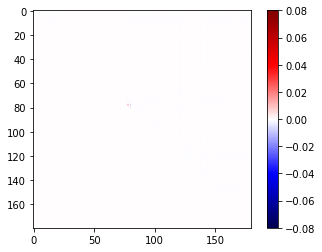

In [5]:
plt.imshow(covariance,cmap='seismic',vmin=-0.08, vmax=0.08)
plt.colorbar()

The correlation matrix can be constructed using the covariance matrix and also give some insight into the relations among the parameters.

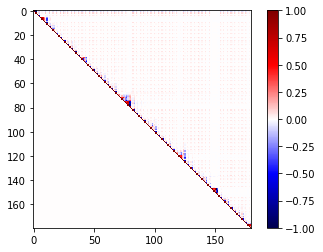

In [6]:
corr = np.zeros([len(covariance),len(covariance)])
for i in range(len(covariance)):
    for j in range(len(covariance)):
        corr[i, j]=covariance[i, j]/covariance[i, i]**(0.5)/covariance[j, j]**(0.5)
plt.imshow(corr, cmap='seismic',vmin=-1.0, vmax=1.0)
plt.colorbar()


### Sampling and Reconstruction

The covariance module also has the ability to sample a new set of parameters using the covariance matrix. Currently the sampling uses numpy.multivariate_normal(). Because parameters are assumed to have a multivariate normal distribution this method doesn't not currently guarantee that sampled parameters will be positive.

In [7]:
rm_resonance = gd157_endf.resonances.ranges[0]
n_samples = 5
samples = gd157_endf.resonance_covariance.ranges[0].sample_resonance_parameters(n_samples, rm_resonance)
type(samples[0])


/home/icmeyer/miniconda3/lib/python3.6/site-packages/openmc-0.10.0-py3.6-linux-x86_64.egg/openmc/data/resonance_covariance.py:239: UserWarning: Sampling routine does not guarantee positive values for parameters. This can lead to undefined behavior in the reconstruction routine.
  warnings.warn(warn_str)


openmc.data.resonance.ReichMoore

The sampling routine requires the incorporation of the `openmc.data.ResonanceRange` for the same resonance range object. This allows each sample itself to be its own `openmc.data.ResonanceRange` with a new set of parameters. Looking at some of the sampled parameters below:

In [8]:
print('Sample 1')
samples[0].parameters[:5]

Sample 1


,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.029309,0,2.0,0.000468,0.110327,0.0,0.0
1,2.827761,0,2.0,0.000359,0.094539,0.0,0.0
2,16.208418,0,1.0,0.000283,0.046995,0.0,0.0
3,16.762322,0,2.0,0.013044,0.078128,0.0,0.0
4,20.557394,0,2.0,0.011103,0.086309,0.0,0.0


In [9]:
print('Sample 2')
samples[1].parameters[:5]

Sample 2


,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.031344,0,2.0,0.000473,0.107136,0.0,0.0
1,2.827026,0,2.0,0.000321,0.102900,0.0,0.0
2,16.242791,0,1.0,0.000479,0.119832,0.0,0.0
3,16.772147,0,2.0,0.013393,0.070252,0.0,0.0
4,20.556324,0,2.0,0.012220,0.077122,0.0,0.0


We can reconstruct the cross section from the sampled parameters using the reconstruct method of  `openmc.data.ResonanceRange`. For more on reconstruction see the Nuclear Data example notebook. 

In [10]:
gd157_endf.resonances.ranges

Text(0,0.5,'Cross section (b)')

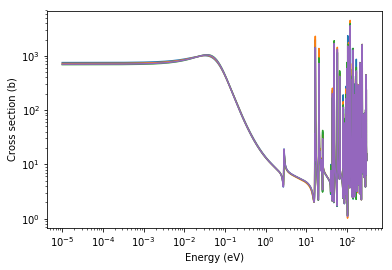

In [11]:
energy_range = [rm_resonance.energy_min, rm_resonance.energy_max]
energies = np.logspace(np.log10(energy_range[0]),
                       np.log10(energy_range[1]), 10000)
for sample in samples:
    xs = sample.reconstruct(energies)
    elastic_xs = xs[2]
    plt.loglog(energies, elastic_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

### Subset Selection

Another capability of the covariance module is selecting a subset of the resonance parameters and the corresponding subset of the covariance matrix. We can do this by specifying the value we want to discriminate and the bounds within one energy region. Selecting only resonances with J=2:

In [12]:
lower_bound = 2;  # inclusive
upper_bound = 2;  # inclusive
rm_resonance_sub, rm_res_cov_sub = gd157_endf.resonance_covariance.ranges[0].res_subset('J',[lower_bound,upper_bound], rm_resonance)
rm_resonance_sub.parameters[:5]

,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.0314,0,2.0,0.000474,0.1072,0.0,0.0
1,2.8250,0,2.0,0.000345,0.0970,0.0,0.0
3,16.7700,0,2.0,0.012800,0.0805,0.0,0.0
4,20.5600,0,2.0,0.011360,0.0880,0.0,0.0
5,21.6500,0,2.0,0.000376,0.1140,0.0,0.0


The subset method will also store the corresponding subset of the covariance matrix

In [13]:
rm_res_cov_sub.covariance
gd157_endf.resonance_covariance.ranges[0].covariance.shape


(180, 180)

Checking the size of the new covariance matrix to be sure it was sampled properly: 

In [14]:
old_n_parameters = gd157_endf.resonance_covariance.ranges[0].parameters.shape[0]
old_shape = gd157_endf.resonance_covariance.ranges[0].covariance.shape
new_n_parameters = rm_resonance_sub.parameters.shape[0]
new_shape = rm_res_cov_sub.covariance.shape
print('Number of parameters\nOriginal: '+str(old_n_parameters)+'\nSubet: '+str(new_n_parameters)+'\nCovariance Size\nOriginal: '+str(old_shape)+'\nSubset: '+str(new_shape))


Number of parameters
Original: 60
Subet: 36
Covariance Size
Original: (180, 180)
Subset: (108, 108)


And finally, we can sample from the subset as well

In [15]:
samples_sub = rm_res_cov_sub.sample_resonance_parameters(n_samples, rm_resonance_sub)
samples_sub[0].parameters[:5]

/home/icmeyer/miniconda3/lib/python3.6/site-packages/openmc-0.10.0-py3.6-linux-x86_64.egg/openmc/data/resonance_covariance.py:239: UserWarning: Sampling routine does not guarantee positive values for parameters. This can lead to undefined behavior in the reconstruction routine.
  warnings.warn(warn_str)


,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.033061,0,2.0,0.000477,0.104286,0.0,0.0
1,2.822758,0,2.0,0.000345,0.101087,0.0,0.0
2,16.772084,0,2.0,0.013277,0.074735,0.0,0.0
3,20.555977,0,2.0,0.011417,0.092437,0.0,0.0
4,21.662213,0,2.0,0.000380,0.122282,0.0,0.0
